In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df = df[['model_year', 'vehicle_weight', 'horsepower', 'engine_displacement', 'fuel_efficiency_mpg']]

In [5]:
df.head()

,model_year,vehicle_weight,horsepower,engine_displacement,fuel_efficiency_mpg
0,2003,3413.433759,159.0,170,13.231729
1,2007,3149.664934,97.0,130,13.688217
2,2018,3079.038997,78.0,170,14.246341
3,2009,2542.392402,NaN,220,16.912736
4,2009,3460.870990,140.0,210,12.488369


<Axes: >

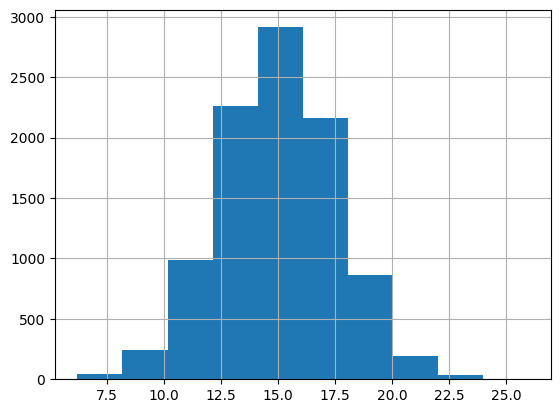

In [6]:
# Look at the fuel_efficiency_mpg variable. Does it have a long tail?
df['fuel_efficiency_mpg'].hist()

In [11]:
df.isna().sum()

model_year               0
vehicle_weight           0
horsepower             708
engine_displacement      0
fuel_efficiency_mpg      0
dtype: int64

In [13]:
df.describe()

,model_year,vehicle_weight,horsepower,engine_displacement,fuel_efficiency_mpg
count,9704.000000,9704.000000,8996.000000,9704.000000,9704.000000
mean,2011.484027,3001.280993,149.657292,199.708368,14.985243
std,6.659808,497.894860,29.879555,49.455319,2.556468
min,2000.000000,952.681761,37.000000,10.000000,6.200971
25%,2006.000000,2666.248985,130.000000,170.000000,13.267459
50%,2012.000000,2993.226296,149.000000,200.000000,15.006037
75%,2017.000000,3334.957039,170.000000,230.000000,16.707965
max,2023.000000,4739.077089,271.000000,380.000000,25.967222


In [16]:
import numpy as np

np.random.seed(42)
n = len(df)
indices = np.arange(n)
np.random.shuffle(indices)

n_train = int(n * 0.6)
n_val = int(n * 0.2)
n_test = n - n_train - n_val

df_train = df.iloc[indices[:n_train]].reset_index(drop=True)
df_val = df.iloc[indices[n_train:n_train + n_val]].reset_index(drop=True)
df_test = df.iloc[indices[n_train + n_val:]].reset_index(drop=True)

In [17]:
def train_and_evaluate(df_train, df_val, fill_value):
    # Fill missing values
    X_train = df_train[['model_year', 'vehicle_weight', 'horsepower', 'engine_displacement']].copy()
    y_train = df_train['fuel_efficiency_mpg'].values
    X_val = df_val[['model_year', 'vehicle_weight', 'horsepower', 'engine_displacement']].copy()
    y_val = df_val['fuel_efficiency_mpg'].values

    X_train['horsepower'] = X_train['horsepower'].fillna(fill_value)
    X_val['horsepower'] = X_val['horsepower'].fillna(fill_value)

    # Add bias term
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values])
    X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val.values])

    # Linear regression (no regularization)
    w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    y_pred = X_val @ w

    # RMSE
    rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
    return round(rmse, 2)

# Option 1: Fill with 0
rmse_zero = train_and_evaluate(df_train, df_val, 0)

# Option 2: Fill with train mean
horsepower_mean = df_train['horsepower'].mean()
rmse_mean = train_and_evaluate(df_train, df_val, horsepower_mean)

print("RMSE (fill 0):", rmse_zero)
print("RMSE (fill mean):", rmse_mean)

RMSE (fill 0): 0.51
RMSE (fill mean): 0.47


In [18]:
def ridge_train_and_evaluate(df_train, df_val, r):
    X_train = df_train[['model_year', 'vehicle_weight', 'horsepower', 'engine_displacement']].copy()
    y_train = df_train['fuel_efficiency_mpg'].values
    X_val = df_val[['model_year', 'vehicle_weight', 'horsepower', 'engine_displacement']].copy()
    y_val = df_val['fuel_efficiency_mpg'].values

    X_train['horsepower'] = X_train['horsepower'].fillna(0)
    X_val['horsepower'] = X_val['horsepower'].fillna(0)

    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train.values])
    X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val.values])

    n_features = X_train.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Don't regularize the bias

    w = np.linalg.inv(X_train.T @ X_train + r * I) @ X_train.T @ y_train
    y_pred = X_val @ w
    rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
    return round(rmse, 2)

r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_results = []

for r in r_list:
    rmse = ridge_train_and_evaluate(df_train, df_val, r)
    rmse_results.append((r, rmse))

# Find the smallest r with the best (lowest) RMSE
best_r, best_rmse = min(rmse_results, key=lambda x: (x[1], x[0]))

print("Best r:", best_r)
print("Best RMSE:", best_rmse)
print("All results:", rmse_results)

Best r: 0
Best RMSE: 0.51
All results: [(0, np.float64(0.51)), (0.01, np.float64(0.51)), (0.1, np.float64(0.51)), (1, np.float64(0.51)), (5, np.float64(0.51)), (10, np.float64(0.51)), (100, np.float64(0.51))]
